In [81]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Audio, display

# Implementation of constrained LMS algorithm
from Frost

We'll start by trying to replicate his results so we know that the algorithm is working correctly. First, I gotta check I remember how filters work, let's calculate the transfer function directly, should match Figure 9

Text(0,0.5,'Magnitude squared')

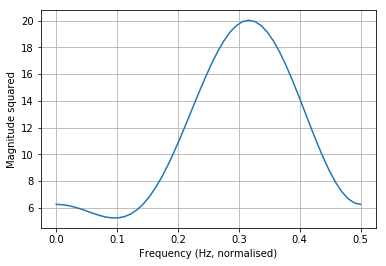

In [9]:
c = np.array([1, -2, 1.5, 2])

# Look at the frequency response of the filter up to the Nyquist frequency, and check it works properly
f = np.linspace(0, 0.5)
H = np.zeros(f.shape, dtype='complex128')
for k in range(4):
    H += c[k]*np.exp(k*1j*2*np.pi*f)

plt.plot(f, abs(H)**2)
plt.grid(True)
plt.xlabel('Frequency (Hz, normalised)')
plt.ylabel('Magnitude squared')


Looks legit, c.f. Fig 9 of paper

## Fractional delay routines
We need these to accurately compute delayed signals. We use a Hamming-windowed shifted sinc function to compute the delayed signal. The function `delay_signal` takes in a delay, expressed as a number of samples. It shifts by the integer part of the delay first by prepending zeros, and then shifts by the fractional part using the filter. 

Note that applying the filter will necessarily shift the signal by an additional $(M-1)/2$ samples, where $M$ is the order of the filter. So all signals should be filtered with this so that the delays are consistent



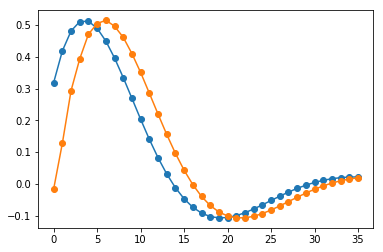

In [180]:
def hamming_symmetric(x, M):
    # Hamming Window, shifted to be centred about 0
    centre = (M - 1)/2
    return 0.54 - 0.46*np.cos(2*np.pi*(x - centre)/(M - 1))

def delay_signal(x_in, d, order=25):
    assert(np.mod(order, 2) == 1)
    
    if d >= 1:
        # delay signal by integer amount of samples by prepending zeros
        d_int = int(np.floor(d))
        x_in = np.concatenate((np.zeros(d_int), x_in[:-d_int]))
        d -= d_int
    
    # build delay FIR filter
    x = np.arange(order) - (order - 1)/2
    h_delay = hamming_symmetric(x - delay, order) * np.sinc(x - delay)
    y = lfilter(h_delay, [1.0], x_in)
    return y

fs = 10
t = np.arange(50)/fs

order = 25
m = int((order - 1)/2)
x = np.exp(-t)*np.sin(2*t)
plt.plot(x[2:-m], '-o')
y = delay_signal(x, 2.6, order)
plt.plot(y[m+2:],'-o')


## Routine for generating bandlimited noise of specified power and band

In [171]:
from scipy.signal import welch, butter, lfilter, hamming

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def generate_bandlimited_noise(fs, ns, center, bandwidth, power, order=9):
    t = np.arange(ns)/fs
    x = np.random.normal(scale=1, size=t.shape)
    y = butter_bandpass_filter(x, center - bandwidth/2, center + bandwidth/2, fs, order=order)
    y /= np.sum(y**2)/ns/np.sqrt(power) 
    return y

## Experimental setup
We assume the microphones are equally spaced at positions $(0, a), (0, 2a), (0, 3a), \ldots, (0, (K-1)a)$, and that sound directions are measured counterclockwise from the _vertical_ axis (not the same as normal). So for angles between $0^\circ$ and $90^\circ$, the incoming plane wave should hit the receiver at the origin first, and then the subsequent receivers one at a time. With speed of sound $c$, the delay (seconds) between the first receiver, and receiver $k$ is 
\begin{equation}
    d_k = \frac{ak \sin \theta}{c}
\end{equation}

## Construct signal and noise sources
According to the Frost, "all signals were generated by a pseudo-Gaussian generator and filtered to give them proper spatial and temporal correlations. All temporal correlations were arranged to be identically zero for time differences greater than $25\tau$". 

I don't believe the paper gives all the information, e.g. the sensor spacing is not specified, and how this relates to the wavelengths of the incoming signals will be important. We'll need to make some assumptions about these things.

<table>
    <tr>
        <td>Source</td>
        <td>Power </td>
        <td>Direction (degrees, from normal)</td>
        <td>Center Frequency</td>
        <td>Bandwidth</td>
    </tr>
    <tr>
        <td>Signal</td>
        <td>0.1</td>
        <td>0</td>
        <td>0.3</td>
        <td>0.1</td>
    </tr>
        <tr>
        <td>Noise A</td>
        <td>1.0</td>
        <td>45</td>
        <td>0.2</td>
        <td>0.05</td>
    </tr>
    <tr>
        <td>Noise B</td>
        <td>1.0</td>
        <td>60</td>
        <td>0.4</td>
        <td>0.07</td>
    </tr>
</table>

In [213]:
ns = 2**16
fs = 8000
c = 340 #m/s

# Total power, not density
noise_power_A = 1.0
noise_power_B = 1.0
signal_power = 0.1

# Construct noises and signal
noise_A = generate_bandlimited_noise(fs, ns, 0.2*fs, 0.05*fs, noise_power_A)
noise_B = generate_bandlimited_noise(fs, ns, 0.4*fs, 0.07*fs, noise_power_B)
signal = generate_bandlimited_noise(fs, ns, 0.3*fs, 0.1*fs, signal_power)

# Create received versions of these signals
K = 4 # number of receivers
a = 0.1 # spacing, in m

# Receiver coordinates (on the x axis)
xk = a*np.arange(K)

# Noise A
n_A = np.zeros((K, ns))
n_B = np.zeros((K, ns))
x_s = np.zeros((K, ns))
theta_a = np.pi/180 * 45
theta_b = np.pi/180 * 60
d_A = xk/c * np.sin(theta_a) * fs # delays, in samples
d_B = xk/c * np.sin(theta_b) * fs
print(d_A)
for k in range(K):
    n_A[k] = delay_signal(noise_A, d_A[k])
    n_B[k] = delay_signal(noise_B, d_B[k])
    x_s[k] = delay_signal(signal, 0)

# Construct signal as sum of incoming sources
X = n_A + n_B + x_s

[0.         1.66378066 3.32756132 4.99134198]


## Crude beamformer
Quick check that things are working right. If we average the signals received from the four channels, then we should get significant reduction in non-look direction signals, as they will be adding incoherently, whereas our look direction signal should be adding coherently.

There are also some audio players so you can compare what they sound like :)

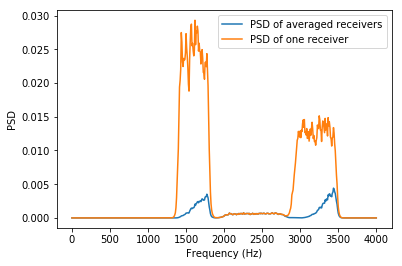

In [215]:
freqs, pxx = welch(sum(X)/K, fs=fs, nperseg=1024)
#plt.semilogy(freqs, pxx)
plt.plot(freqs, pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')

freqs, pxx = welch(X[0], fs=fs, nperseg=1024)
plt.plot(freqs, pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')

plt.legend(('PSD of averaged receivers', 'PSD of one receiver'))

display(Audio(data = sum(X)/K, rate=fs))
display(Audio(data = X[0], rate=fs))



## First cut at using Frost Beamformer

Text(0,0.5,'PSD')

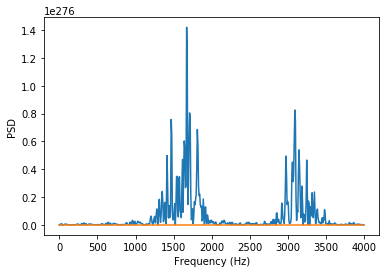

In [229]:
import beamform
f_ideal = np.array([1, -2, 1.5, 2])

foo = beamform.beamform(4, f_ideal)
y = np.zeros(ns)
for n in range(ns):
    y[n] = foo.filter(X[:, n])
    if n > 0 and np.mod(n, 25) == 0:
        foo.update_weights()
        
freqs, pxx = welch(y, fs=fs, nperseg=1024)
#plt.semilogy(freqs, pxx)
plt.plot(freqs, pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')

freqs, pxx = welch(X[0], fs=fs, nperseg=1024)
plt.plot(freqs, pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')